In [1]:
!pip install pot
!pip install torch
!pip install geomloss
!pip install wget


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from geomloss import SamplesLoss

import ot

import os
import pickle as pkl
import copy

from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from utils import *
from SoftImpute import softimpute, cv_softimpute
from DataSetLoader import dataset_loader, ground_truth
from Experimental_Sinkhorn import Sinkhorn
from Loss_Calculation import Loss_Calculation
from RR_imputer import RRimputer
import matplotlib.pyplot as plt

import argparse
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

torch.set_default_tensor_type('torch.DoubleTensor')

c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [3]:
from sklearn.datasets import load_wine
ground_truth_numpy = scale(load_wine()['data'])

In [4]:
Xy = {}
with open(r'C:\Users\zhossai3\Desktop\My code\OT+Fairness\Data\portugal student performance dataset\P_Student_Performance_Data.csv', 'rb') as f:
        df = pd.read_csv(f, delimiter=',', header = 0)
        Xy['data'] = df.values[:, :-1].astype('float')
        Xy['target'] =  df.values[:, -1]

In [5]:
#ground_truth_numpy = (Xy['data'])
print(type(ground_truth_numpy))

<class 'numpy.ndarray'>


In [6]:
print(type(ground_truth_numpy))
print(np.max(ground_truth_numpy))
print(np.min(ground_truth_numpy))
print(np.mean(ground_truth_numpy))
print(np.median(ground_truth_numpy))
print(np.std(ground_truth_numpy))
print(ground_truth_numpy.shape)
np.isnan(ground_truth_numpy).sum()

<class 'numpy.ndarray'>
4.371372139554767
-3.6791622340370145
4.66735072755122e-16
-0.08109900443171775
1.0
(178, 13)


np.int64(0)

In [7]:
type(ground_truth_numpy)

numpy.ndarray

In [8]:
ground_truth = torch.from_numpy(ground_truth_numpy)

In [9]:
print(ground_truth)

tensor([[ 1.5186, -0.5622,  0.2321,  ...,  0.3622,  1.8479,  1.0130],
        [ 0.2463, -0.4994, -0.8280,  ...,  0.4061,  1.1134,  0.9652],
        [ 0.1969,  0.0212,  1.1093,  ...,  0.3183,  0.7886,  1.3951],
        ...,
        [ 0.3328,  1.7447, -0.3894,  ..., -1.6121, -1.4854,  0.2806],
        [ 0.2092,  0.2277,  0.0127,  ..., -1.5683, -1.4007,  0.2965],
        [ 1.3951,  1.5832,  1.3652,  ..., -1.5244, -1.4289, -0.5952]])


In [10]:
#30% MCAR
np.random.seed(42)

p_macr30 = 0.3


mask_mcar30 = np.random.rand(*ground_truth.shape) < p_macr30  # True for missing values, false for others
data_mcar30 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar30[mask_mcar30] = np.nan

# Convert to a torch tensor
data_mcar30 = torch.from_numpy(data_mcar30)

# Calculate the percentage of missing values
missing_values_mcar30 = torch.isnan(data_mcar30)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar30 = torch.sum(missing_values_mcar30).item() / data_mcar30.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar30:.2f}%")

Percentage of missing values: 30.73%


In [11]:
data_mcar30

tensor([[ 1.5186, -0.5622,  0.2321,  ...,     nan,  1.8479,  1.0130],
        [    nan,     nan,     nan,  ...,  0.4061,  1.1134,  0.9652],
        [    nan,  0.0212,  1.1093,  ...,  0.3183,     nan,  1.3951],
        ...,
        [ 0.3328,  1.7447, -0.3894,  ...,     nan, -1.4854,  0.2806],
        [ 0.2092,     nan,  0.0127,  ...,     nan, -1.4007,  0.2965],
        [ 1.3951,  1.5832,     nan,  ..., -1.5244, -1.4289, -0.5952]])

In [12]:
#30% MAR
np.random.seed(42)
torch.manual_seed(42)
mask_mar30, missing_ind_mar= MAR_mask(ground_truth_numpy, 0.65, 0.55)
data_mar30 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mar30[mask_mar30] = np.nan

# Convert to a torch tensor
data_mar30 = torch.from_numpy(data_mar30)

# Calculate the percentage of missing values
missing_values_mar30 = torch.isnan(data_mar30)  
missing_percentage_mar30 = torch.sum(missing_values_mar30).item() / data_mar30.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mar30:.2f}%")

Percentage of missing values: 30.68%


In [13]:
print(data_mar30)

tensor([[ 1.5186, -0.5622,  0.2321,  ...,     nan,  1.8479,     nan],
        [ 0.2463, -0.4994, -0.8280,  ...,     nan,  1.1134,     nan],
        [ 0.1969,  0.0212,  1.1093,  ...,     nan,  0.7886,     nan],
        ...,
        [ 0.3328,  1.7447, -0.3894,  ...,     nan, -1.4854,     nan],
        [ 0.2092,  0.2277,  0.0127,  ..., -1.5683, -1.4007,     nan],
        [ 1.3951,  1.5832,  1.3652,  ..., -1.5244, -1.4289,     nan]])


In [14]:
#30% MNAR
np.random.seed(42)
torch.manual_seed(42)
mask_mnar30= MNAR_mask_quantiles(ground_truth_numpy, 0.65, 0.55, 0.5)
data_mnar30 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mnar30[mask_mnar30] = np.nan

# Convert to a torch tensor
data_mnar30 = torch.from_numpy(data_mnar30)

# Calculate the percentage of missing values
missing_values_mnar30 = torch.isnan(data_mnar30)  
missing_percentage_mnar30 = torch.sum(missing_values_mnar30).item() / data_mnar30.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mnar30:.2f}%")

Percentage of missing values: 30.90%


In [15]:
data_mnar30

tensor([[    nan, -0.5622,     nan,  ...,  0.3622,     nan,  1.0130],
        [    nan, -0.4994,     nan,  ...,  0.4061,  1.1134,  0.9652],
        [    nan,  0.0212,  1.1093,  ...,  0.3183,  0.7886,  1.3951],
        ...,
        [    nan,  1.7447,     nan,  ..., -1.6121,     nan,  0.2806],
        [ 0.2092,  0.2277,     nan,  ..., -1.5683,     nan,  0.2965],
        [ 1.3951,  1.5832,     nan,  ..., -1.5244,     nan, -0.5952]])

In [16]:
#sinkhorn 30% mcar
n_mcar30, d_mcar30 = data_mcar30.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar30 = pick_epsilon(data_mcar30)
print(epsilon_mcar30)

sk_imputer_mcar30 = Sinkhorn(eps=epsilon_mcar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar30, sk_maes30mcar, sk_rmses30mcar,imps_mean_mcar30,imps_mcar30,loss_history_mcar30,sk_imp_mcar30_mean,loss_vision_mcar30= sk_imputer_mcar30.fit_transform(data_mcar30, verbose=True, report_interval=500, X_true=ground_truth)
#using numpy version of data
sk_imp_mcar30_numpy = sk_imp_mcar30.detach().cpu().numpy()

sk_mae_mcar30 = MAE(sk_imp_mcar30_numpy,ground_truth_numpy ,mask_mcar30)
sk_rmse_mcar30 = RMSE(sk_imp_mcar30_numpy, ground_truth_numpy,mask_mcar30)
print(sk_mae_mcar30,sk_rmse_mcar30)

0.39971389591590073


INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.3997
INFO:root:Iteration 0:	 Loss: 2.1797	 Validation MAE: 0.8400	RMSE: 1.0407
INFO:root:Iteration 500:	 Loss: 1.6930	 Validation MAE: 0.5805	RMSE: 0.7985
INFO:root:Iteration 1000:	 Loss: 1.6578	 Validation MAE: 0.5740	RMSE: 0.7936
INFO:root:Iteration 1500:	 Loss: 1.8636	 Validation MAE: 0.5781	RMSE: 0.7963


0.5849384959623575 0.8040251248060182


In [17]:
#sinkhorn 30% mar
n_mar30, d_mar30 = data_mar30.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mar30 = pick_epsilon(data_mar30)
print(epsilon_mar30)

sk_imputer_mar30 = Sinkhorn(eps=epsilon_mar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mar30, sk_maes30mar, sk_rmses30mar,imps_mean_mar30,imps_mar30,loss_history_mar30, sk_imp_mar30_mean,loss_vision_mar30= sk_imputer_mar30.fit_transform(data_mar30, verbose=True, report_interval=500, X_true=ground_truth)
#using numpy version of data
sk_imp_mar30_numpy = sk_imp_mar30.detach().cpu().numpy()

sk_mae_mar30 = MAE(sk_imp_mar30_numpy,ground_truth_numpy ,mask_mar30)
sk_rmse_mar30 = RMSE(sk_imp_mar30_numpy, ground_truth_numpy,mask_mar30)
print(sk_mae_mar30,sk_rmse_mar30)    

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.4114
INFO:root:Iteration 0:	 Loss: 1.7871	 Validation MAE: 0.8318	RMSE: 1.0238


0.41144367571495305


INFO:root:Iteration 500:	 Loss: 1.2681	 Validation MAE: 0.5704	RMSE: 0.7562
INFO:root:Iteration 1000:	 Loss: 1.4779	 Validation MAE: 0.5577	RMSE: 0.7444
INFO:root:Iteration 1500:	 Loss: 1.4336	 Validation MAE: 0.5548	RMSE: 0.7424


0.5545587752674288 0.7442104478911177


In [18]:
#sinkhorn 30% mar
n_mnar30, d_mnar30 = data_mnar30.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mnar30 = pick_epsilon(data_mnar30)
print(epsilon_mnar30)

sk_imputer_mnar30 = Sinkhorn(eps=epsilon_mnar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mnar30, sk_maes30mnar, sk_rmses30mnar,imps_mean_mnar30,imps_mnar30,loss_history_mnar30, sk_imp_mnar30_mean,loss_vision_mnar30= sk_imputer_mnar30.fit_transform(data_mnar30, verbose=True, report_interval=500, X_true=ground_truth)
#using numpy version of data
sk_imp_mnar30_numpy = sk_imp_mnar30.detach().cpu().numpy()

sk_mae_mnar30 = MAE(sk_imp_mnar30_numpy,ground_truth_numpy ,mask_mnar30)
sk_rmse_mnar30 = RMSE(sk_imp_mnar30_numpy, ground_truth_numpy,mask_mnar30)
print(sk_mae_mnar30,sk_rmse_mnar30)    

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.4238
INFO:root:Iteration 0:	 Loss: 1.7599	 Validation MAE: 0.8133	RMSE: 0.9996


0.4238241822858288


INFO:root:Iteration 500:	 Loss: 1.5286	 Validation MAE: 0.5312	RMSE: 0.7039
INFO:root:Iteration 1000:	 Loss: 1.5661	 Validation MAE: 0.5307	RMSE: 0.7058
INFO:root:Iteration 1500:	 Loss: 1.6835	 Validation MAE: 0.5279	RMSE: 0.6990


0.5323694132525335 0.7058570476783171


In [19]:
imps_mcar30.values

<function Tensor.values>

In [20]:
similarity_mcar30 = imps_mean_mnar30 == imps_mnar30.detach()
print(similarity_mcar30)

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

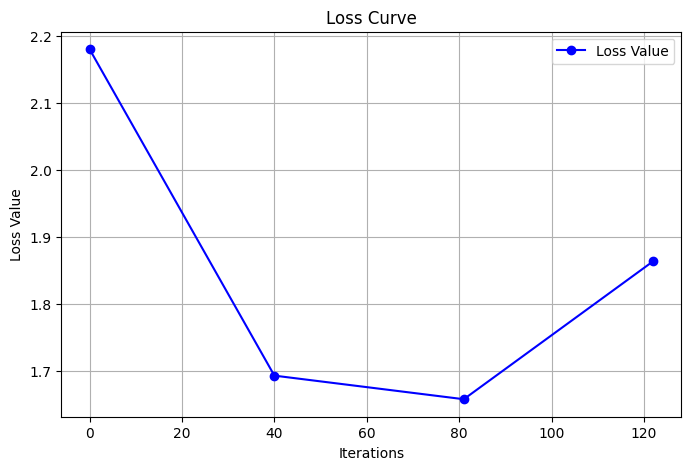

In [21]:
# Convert the list of losses to a NumPy array

iterations = np.linspace(0, 2000, 50).astype(int)



loss_values = loss_vision_mcar30


# Assuming cmi_penalty_history is also a list, convert it to a NumPy array
#cmi_penalty_history_numpy = np.array(cmi_penalty_history)

# Total loss calculation
#total_loss = sk_loss_mcar30_numpy + cmi_penalty_history_numpy
if len(loss_values) > len(iterations):
    loss_values = loss_values[:len(iterations)]
elif len(loss_values) < len(iterations):
    iterations = iterations[:len(loss_values)]



# Plotting
plt.figure(figsize=(8, 5))
plt.plot(iterations, loss_values, color='b', linestyle='-', marker='o', label="Loss Value")
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



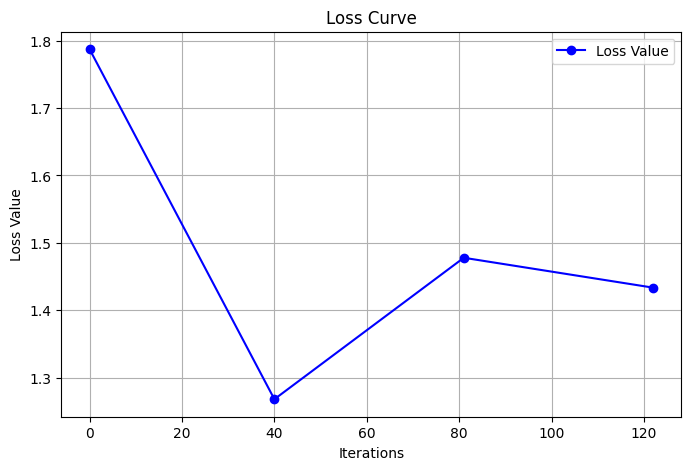

In [22]:
# Convert the list of losses to a NumPy array

iterations = np.linspace(0, 2000, 50).astype(int)



loss_values = loss_vision_mar30


# Assuming cmi_penalty_history is also a list, convert it to a NumPy array
#cmi_penalty_history_numpy = np.array(cmi_penalty_history)

# Total loss calculation
#total_loss = sk_loss_mcar30_numpy + cmi_penalty_history_numpy
if len(loss_values) > len(iterations):
    loss_values = loss_values[:len(iterations)]
elif len(loss_values) < len(iterations):
    iterations = iterations[:len(loss_values)]



# Plotting
plt.figure(figsize=(8, 5))
plt.plot(iterations, loss_values, color='b', linestyle='-', marker='o', label="Loss Value")
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



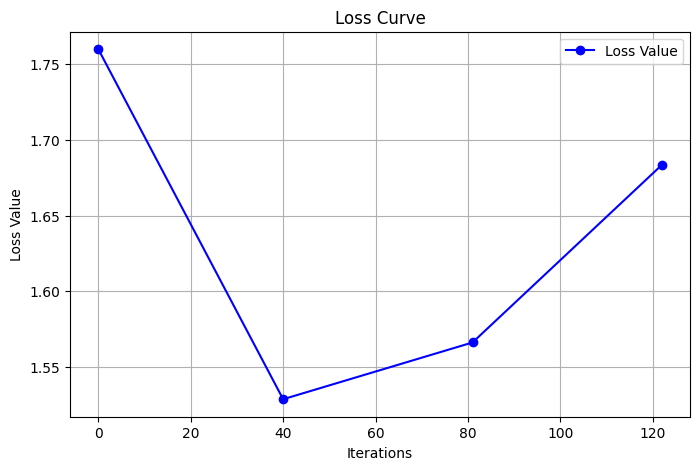

In [23]:
# Convert the list of losses to a NumPy array

iterations = np.linspace(0, 2000, 50).astype(int)



loss_values = loss_vision_mnar30


# Assuming cmi_penalty_history is also a list, convert it to a NumPy array
#cmi_penalty_history_numpy = np.array(cmi_penalty_history)

# Total loss calculation
#total_loss = sk_loss_mcar30_numpy + cmi_penalty_history_numpy
if len(loss_values) > len(iterations):
    loss_values = loss_values[:len(iterations)]
elif len(loss_values) < len(iterations):
    iterations = iterations[:len(loss_values)]



# Plotting
plt.figure(figsize=(8, 5))
plt.plot(iterations, loss_values, color='b', linestyle='-', marker='o', label="Loss Value")
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



In [24]:
#Loss Calculation 30% imps_mcar

batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_imp_mcar30 = pick_epsilon(sk_imp_mcar30)

loss_mcar30 = Loss_Calculation(eps=epsilon_imp_mcar30, batchsize=batchsize, lr=lr, niter=100)
loss_h_mcar30 = loss_mcar30.transform(sk_imp_mcar30, verbose=True, report_interval=500)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.5190


[ 19  45 140  30  67  16 119 174 109 141  24 150  41 118  15 111 113  82
   9 114  18  66  60 169 171 164 117  65  90  55  29 128 145  31  12  42
 158 137  98 159  38 108  85  68 143   2 100 122 154  51  76  56  26 153
 138 104  78  36  93  22 146  97  69 167]
[152 145 109  76 114  12  42  99  62  25 177  14 166  63 106  84 148 147
  57   9  82 101  48 137 155 133 105  94  46  72 144 124 108   5  28 118
  43 153  78   3 172   4 143  27  64  55  87  33 116  26 174  77  44 162
  85  29  45 107  54  21 169 167 141  70]
loss tensor(1.3692)
[157 168  55  37  70  43  44  81  13 162 116  76  80  24 136 159 131  10
  78  17  20 164   6 133  67 166 121  40  86  41 140 111 119  73  87 138
  30  45 150  84  71 127  58 156   2 139  36  42 144  74  34 173 137 135
 165  26 155  27 145   1 160  96  23  83]
[120  33 152  45  40 117  81  54  50  34 130 167  78  21 163  39 176   1
  84 126 109 145  79  67  63 125  49  47  96 156  92 102 135 147 129 137
 124 101  42  77  25 114 134 118 153  23  59  80 12

In [25]:
#Loss Calculation 30% mcar

batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_imp_mcar30 = pick_epsilon(data_mcar30)

loss_withoi_mcar30 = Loss_Calculation(eps=epsilon_imp_mcar30, batchsize=batchsize, lr=lr, niter=100)
loss_wi_mcar30 = loss_withoi_mcar30.transform(data_mcar30, verbose=True, report_interval=500)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.3997


[ 19  45 140  30  67  16 119 174 109 141  24 150  41 118  15 111 113  82
   9 114  18  66  60 169 171 164 117  65  90  55  29 128 145  31  12  42
 158 137  98 159  38 108  85  68 143   2 100 122 154  51  76  56  26 153
 138 104  78  36  93  22 146  97  69 167]
[152 145 109  76 114  12  42  99  62  25 177  14 166  63 106  84 148 147
  57   9  82 101  48 137 155 133 105  94  46  72 144 124 108   5  28 118
  43 153  78   3 172   4 143  27  64  55  87  33 116  26 174  77  44 162
  85  29  45 107  54  21 169 167 141  70]
loss tensor(2.0795)
[157 168  55  37  70  43  44  81  13 162 116  76  80  24 136 159 131  10
  78  17  20 164   6 133  67 166 121  40  86  41 140 111 119  73  87 138
  30  45 150  84  71 127  58 156   2 139  36  42 144  74  34 173 137 135
 165  26 155  27 145   1 160  96  23  83]
[120  33 152  45  40 117  81  54  50  34 130 167  78  21 163  39 176   1
  84 126 109 145  79  67  63 125  49  47  96 156  92 102 135 147 129 137
 124 101  42  77  25 114 134 118 153  23  59  80 12

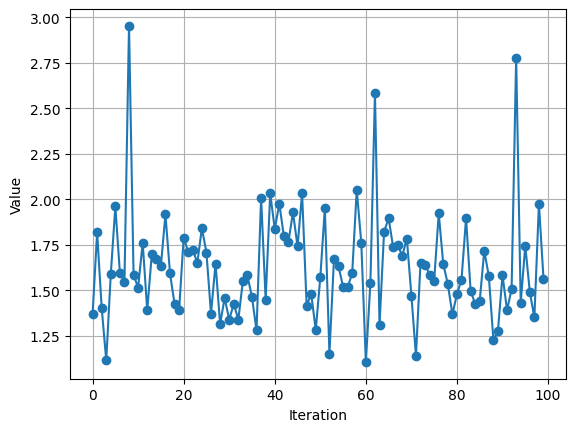

In [26]:
import matplotlib.pyplot as plt


plt.figure()
plt.plot(loss_h_mcar30, marker='o')
        #plt.title(f"Changes for imps[{index[0]}, {index[1]}]")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.grid(True)
plt.show()


In [27]:
#Loss Calculation 30% sk_imps_mar

batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_imp_mar30 = pick_epsilon(sk_imp_mar30)
print(epsilon_imp_mar30)

loss_mar30 = Loss_Calculation(eps=epsilon_imp_mar30, batchsize=batchsize, lr=lr, niter=100)
loss_h_mar30= loss_mar30.transform(sk_imp_mar30, verbose=True, report_interval=500)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.4951


0.4950711731002468
[ 19  45 140  30  67  16 119 174 109 141  24 150  41 118  15 111 113  82
   9 114  18  66  60 169 171 164 117  65  90  55  29 128 145  31  12  42
 158 137  98 159  38 108  85  68 143   2 100 122 154  51  76  56  26 153
 138 104  78  36  93  22 146  97  69 167]
[152 145 109  76 114  12  42  99  62  25 177  14 166  63 106  84 148 147
  57   9  82 101  48 137 155 133 105  94  46  72 144 124 108   5  28 118
  43 153  78   3 172   4 143  27  64  55  87  33 116  26 174  77  44 162
  85  29  45 107  54  21 169 167 141  70]
loss tensor(1.2891)
[157 168  55  37  70  43  44  81  13 162 116  76  80  24 136 159 131  10
  78  17  20 164   6 133  67 166 121  40  86  41 140 111 119  73  87 138
  30  45 150  84  71 127  58 156   2 139  36  42 144  74  34 173 137 135
 165  26 155  27 145   1 160  96  23  83]
[120  33 152  45  40 117  81  54  50  34 130 167  78  21 163  39 176   1
  84 126 109 145  79  67  63 125  49  47  96 156  92 102 135 147 129 137
 124 101  42  77  25 114 134 118

In [28]:
#Loss Calculation 30% mar

batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_imp_mar30 = pick_epsilon(data_mar30)

loss_withoi_mar30 = Loss_Calculation(eps=epsilon_imp_mar30, batchsize=batchsize, lr=lr, niter=100)
loss_wi_mar30 = loss_withoi_mar30.transform(data_mar30, verbose=True, report_interval=500)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.4114


[ 19  45 140  30  67  16 119 174 109 141  24 150  41 118  15 111 113  82
   9 114  18  66  60 169 171 164 117  65  90  55  29 128 145  31  12  42
 158 137  98 159  38 108  85  68 143   2 100 122 154  51  76  56  26 153
 138 104  78  36  93  22 146  97  69 167]
[152 145 109  76 114  12  42  99  62  25 177  14 166  63 106  84 148 147
  57   9  82 101  48 137 155 133 105  94  46  72 144 124 108   5  28 118
  43 153  78   3 172   4 143  27  64  55  87  33 116  26 174  77  44 162
  85  29  45 107  54  21 169 167 141  70]
loss tensor(1.6197)
[157 168  55  37  70  43  44  81  13 162 116  76  80  24 136 159 131  10
  78  17  20 164   6 133  67 166 121  40  86  41 140 111 119  73  87 138
  30  45 150  84  71 127  58 156   2 139  36  42 144  74  34 173 137 135
 165  26 155  27 145   1 160  96  23  83]
[120  33 152  45  40 117  81  54  50  34 130 167  78  21 163  39 176   1
  84 126 109 145  79  67  63 125  49  47  96 156  92 102 135 147 129 137
 124 101  42  77  25 114 134 118 153  23  59  80 12

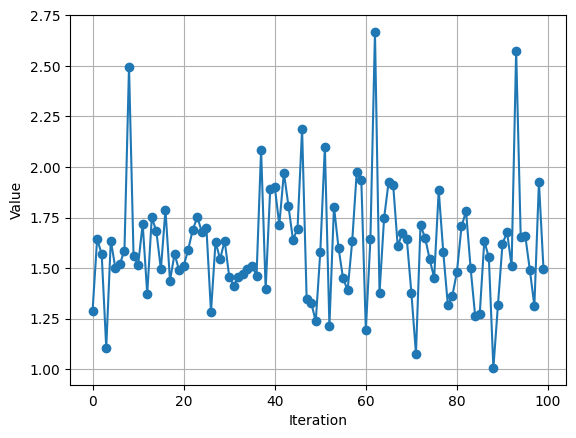

In [29]:
import matplotlib.pyplot as plt


plt.figure()
plt.plot(loss_h_mar30, marker='o')
        #plt.title(f"Changes for imps[{index[0]}, {index[1]}]")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.grid(True)
plt.show()

In [30]:
#Loss Calculation 30% mnar

batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_imp_mnar30 = pick_epsilon(sk_imp_mnar30)


loss_mnar30 = Loss_Calculation(eps=epsilon_imp_mnar30, batchsize=batchsize, lr=lr, niter=100)
loss_h_mnar30= loss_mnar30.transform(sk_imp_mnar30, verbose=True, report_interval=500)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.5318


[ 19  45 140  30  67  16 119 174 109 141  24 150  41 118  15 111 113  82
   9 114  18  66  60 169 171 164 117  65  90  55  29 128 145  31  12  42
 158 137  98 159  38 108  85  68 143   2 100 122 154  51  76  56  26 153
 138 104  78  36  93  22 146  97  69 167]
[152 145 109  76 114  12  42  99  62  25 177  14 166  63 106  84 148 147
  57   9  82 101  48 137 155 133 105  94  46  72 144 124 108   5  28 118
  43 153  78   3 172   4 143  27  64  55  87  33 116  26 174  77  44 162
  85  29  45 107  54  21 169 167 141  70]
loss tensor(1.4837)
[157 168  55  37  70  43  44  81  13 162 116  76  80  24 136 159 131  10
  78  17  20 164   6 133  67 166 121  40  86  41 140 111 119  73  87 138
  30  45 150  84  71 127  58 156   2 139  36  42 144  74  34 173 137 135
 165  26 155  27 145   1 160  96  23  83]
[120  33 152  45  40 117  81  54  50  34 130 167  78  21 163  39 176   1
  84 126 109 145  79  67  63 125  49  47  96 156  92 102 135 147 129 137
 124 101  42  77  25 114 134 118 153  23  59  80 12

In [31]:
#Loss Calculation 30% mnar

batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_imp_mnar30 = pick_epsilon(data_mnar30)

loss_withoi_mnar30 = Loss_Calculation(eps=epsilon_imp_mnar30, batchsize=batchsize, lr=lr, niter=100)
loss_wi_mnar30 = loss_withoi_mnar30.transform(data_mnar30, verbose=True, report_interval=500)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.4238


[ 19  45 140  30  67  16 119 174 109 141  24 150  41 118  15 111 113  82
   9 114  18  66  60 169 171 164 117  65  90  55  29 128 145  31  12  42
 158 137  98 159  38 108  85  68 143   2 100 122 154  51  76  56  26 153
 138 104  78  36  93  22 146  97  69 167]
[152 145 109  76 114  12  42  99  62  25 177  14 166  63 106  84 148 147
  57   9  82 101  48 137 155 133 105  94  46  72 144 124 108   5  28 118
  43 153  78   3 172   4 143  27  64  55  87  33 116  26 174  77  44 162
  85  29  45 107  54  21 169 167 141  70]
loss tensor(1.8199)
[157 168  55  37  70  43  44  81  13 162 116  76  80  24 136 159 131  10
  78  17  20 164   6 133  67 166 121  40  86  41 140 111 119  73  87 138
  30  45 150  84  71 127  58 156   2 139  36  42 144  74  34 173 137 135
 165  26 155  27 145   1 160  96  23  83]
[120  33 152  45  40 117  81  54  50  34 130 167  78  21 163  39 176   1
  84 126 109 145  79  67  63 125  49  47  96 156  92 102 135 147 129 137
 124 101  42  77  25 114 134 118 153  23  59  80 12

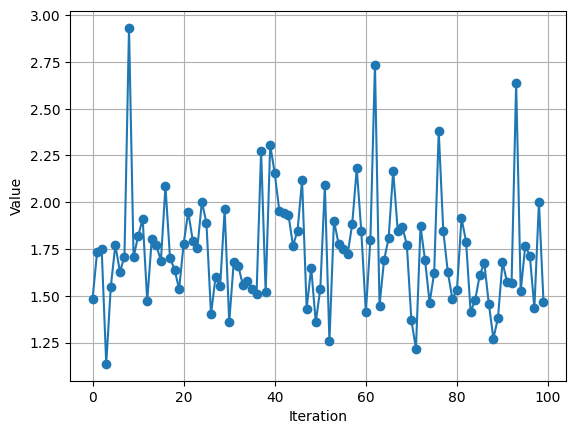

In [32]:
import matplotlib.pyplot as plt


plt.figure()
plt.plot(loss_h_mnar30, marker='o')
        #plt.title(f"Changes for imps[{index[0]}, {index[1]}]")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.grid(True)
plt.show()

In [33]:
print(loss_h_mcar30)
print(loss_wi_mcar30)
print(loss_h_mar30)
print(loss_wi_mar30)
print(loss_h_mnar30)
print(loss_wi_mnar30)

[1.3691675801632042, 1.8182064497526005, 1.4039477100941589, 1.1158013195978256, 1.5898330996401449, 1.9612095190423493, 1.594232198626337, 1.5469577793112959, 2.951927686387774, 1.5858157972411835, 1.5141830485916974, 1.761622613681143, 1.3901009146350818, 1.6978880043990154, 1.6702585137125534, 1.635525730323435, 1.9169628713288493, 1.5924831555707746, 1.425483632541268, 1.3914825290532369, 1.7895083770584872, 1.709934190114183, 1.7229021778447953, 1.6506949793823342, 1.8415039953267187, 1.7070369771506386, 1.371885276724738, 1.6467664673482116, 1.3143161804806458, 1.458444470738274, 1.3389022463778977, 1.4258700054038425, 1.3388610640374536, 1.5512323093251656, 1.5821426009817867, 1.4618446108045053, 1.280343037667873, 2.0082385415064437, 1.4492339434649855, 2.0322804607845106, 1.8366324598168733, 1.9757440295243913, 1.7975815205690227, 1.765738411918012, 1.928688083797038, 1.7410110903817464, 2.0323441822076127, 1.4163189269435938, 1.4806576213002876, 1.2822563187538645, 1.57153513

In [34]:
changed_values_mcar30 = abs(sk_imp_mcar30_mean - sk_imp_mcar30)
print(abs(sk_imp_mcar30_mean - sk_imp_mcar30))

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.5544, 0.0000, 0.0000],
        [1.6579, 0.7693, 0.4834,  ..., 0.0000, 0.0000, 0.0000],
        [0.9077, 0.0000, 0.0000,  ..., 0.0000, 0.3895, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.1332, 0.0000, 0.0000],
        [0.0000, 1.3667, 0.0000,  ..., 0.9454, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3826,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<AbsBackward0>)


In [35]:
import torch

# Example tensor


# Calculate the sum of non-zero values for each column
non_zero_sums = changed_values_mcar30.where(changed_values_mcar30> 0, torch.tensor(0.0)).sum(dim=0)
#print(non_zero_sums)

# Calculate the count of non-zero values for each column
non_zero_counts = (changed_values_mcar30 > 0).sum(dim=0)
#print(non_zero_counts)

# Calculate the average of non-zero values for each column
non_zero_averages = (non_zero_sums / non_zero_counts)*100
non_zero_averages[non_zero_counts == 0] = 0  # Handle columns with no non-zero values

# Display the results
print("Column-wise Average of Non-Zero Values:")
for col_idx, avg in enumerate(non_zero_averages):
    print(f"Column {col_idx}: {avg:.4f}")


Column-wise Average of Non-Zero Values:
Column 0: 75.1945
Column 1: 65.7577
Column 2: 40.6420
Column 3: 59.4200
Column 4: 45.1862
Column 5: 69.7623
Column 6: 80.6713
Column 7: 68.9110
Column 8: 59.0967
Column 9: 56.7499
Column 10: 64.4010
Column 11: 70.6296
Column 12: 68.9156


In [36]:
changed_values_mar30 = abs(sk_imp_mar30_mean - sk_imp_mar30)
print(abs(sk_imp_mar30_mean - sk_imp_mar30))

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.6305, 0.0000, 1.0784],
        [0.0000, 0.0000, 0.0000,  ..., 0.4232, 0.0000, 0.5507],
        [0.0000, 0.0000, 0.0000,  ..., 1.0148, 0.0000, 0.7677],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.1323, 0.0000, 0.5198],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.3487],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0741]],
       grad_fn=<AbsBackward0>)


In [37]:
import torch

# Example tensor


# Calculate the sum of non-zero values for each column
non_zero_sums = changed_values_mar30.where(changed_values_mar30> 0, torch.tensor(0.0)).sum(dim=0)
#print(non_zero_sums)

# Calculate the count of non-zero values for each column
non_zero_counts = (changed_values_mar30 > 0).sum(dim=0)
#print(non_zero_counts)

# Calculate the average of non-zero values for each column
non_zero_averages = (non_zero_sums / non_zero_counts)*100
non_zero_averages[non_zero_counts == 0] = 0  # Handle columns with no non-zero values

# Display the results
print("Column-wise Average of Non-Zero Values:")
for col_idx, avg in enumerate(non_zero_averages):
    print(f"Column {col_idx}: {avg:.4f}")


Column-wise Average of Non-Zero Values:
Column 0: 0.0000
Column 1: 0.0000
Column 2: 0.0000
Column 3: 35.0226
Column 4: 34.3754
Column 5: 0.0000
Column 6: 81.5054
Column 7: 49.4220
Column 8: 0.0000
Column 9: 0.0000
Column 10: 60.8068
Column 11: 0.0000
Column 12: 57.7077


In [38]:
changed_values_mnar30 = abs(sk_imp_mnar30_mean - sk_imp_mnar30)
print(abs(sk_imp_mnar30_mean - sk_imp_mnar30))

tensor([[0.6732, 0.0000, 0.2039,  ..., 0.0000, 0.6536, 0.0000],
        [1.1980, 0.0000, 0.4534,  ..., 0.0000, 0.0000, 0.0000],
        [0.7531, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1303, 0.0000, 0.2539,  ..., 0.0000, 0.9946, 0.0000],
        [0.0000, 0.0000, 0.0018,  ..., 0.0000, 1.2399, 0.0000],
        [0.0000, 0.0000, 0.3557,  ..., 0.0000, 1.0968, 0.0000]],
       grad_fn=<AbsBackward0>)


In [39]:
import torch

# Example tensor


# Calculate the sum of non-zero values for each column
non_zero_sums = changed_values_mnar30.where(changed_values_mnar30> 0, torch.tensor(0.0)).sum(dim=0)
#print(non_zero_sums)

# Calculate the count of non-zero values for each column
non_zero_counts = (changed_values_mnar30 > 0).sum(dim=0)
#print(non_zero_counts)

# Calculate the average of non-zero values for each column
non_zero_averages = (non_zero_sums / non_zero_counts)*100
non_zero_averages[non_zero_counts == 0] = 0  # Handle columns with no non-zero values

# Display the results
print("Column-wise Average of Non-Zero Values:")
for col_idx, avg in enumerate(non_zero_averages):
    print(f"Column {col_idx}: {avg:.4f}")


Column-wise Average of Non-Zero Values:
Column 0: 57.3322
Column 1: 0.0000
Column 2: 47.5371
Column 3: 0.0000
Column 4: 0.0000
Column 5: 64.3426
Column 6: 0.0000
Column 7: 0.0000
Column 8: 55.9302
Column 9: 54.3491
Column 10: 0.0000
Column 11: 67.6848
Column 12: 0.0000


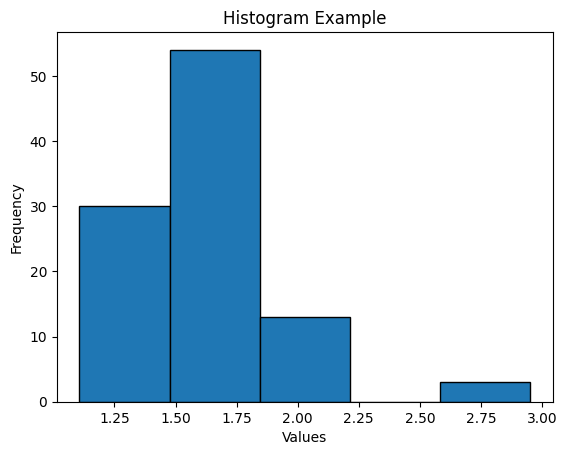

In [40]:
plt.hist(loss_h_mcar30, bins=5, edgecolor='black')  # bins: number of bins for grouping data
plt.title('Histogram Example')  # Title of the plot
plt.xlabel('Values')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.show()

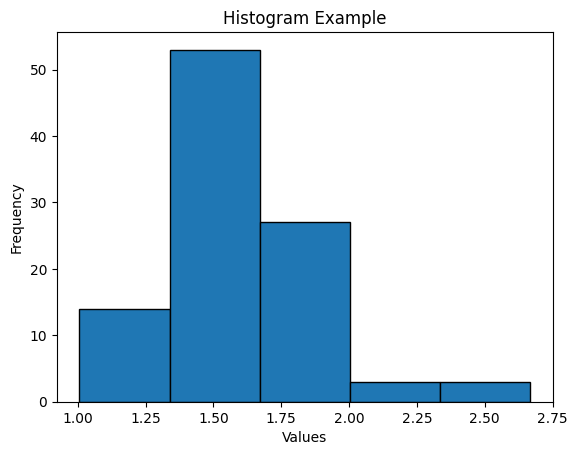

In [41]:
plt.hist(loss_h_mar30, bins=5, edgecolor='black')  # bins: number of bins for grouping data
plt.title('Histogram Example')  # Title of the plot
plt.xlabel('Values')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.show()

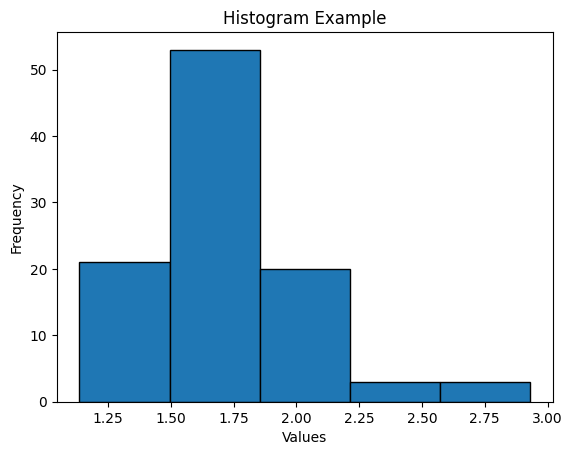

In [42]:
plt.hist(loss_h_mnar30, bins=5, edgecolor='black')  # bins: number of bins for grouping data
plt.title('Histogram Example')  # Title of the plot
plt.xlabel('Values')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.show()

C:\Users\zhossai3\AppData\Local\Temp\ipykernel_6632\196198122.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(loss_h_mcar30, shade=True)  # `shade=True` fills the area under the curve


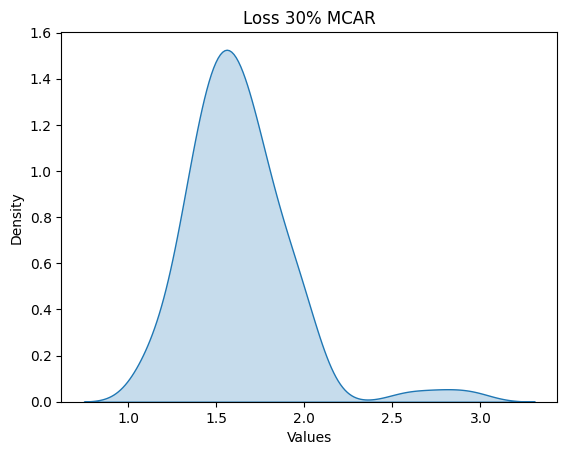

In [43]:
import seaborn as sns
sns.kdeplot(loss_h_mcar30, shade=True)  # `shade=True` fills the area under the curve
plt.title('Loss 30% MCAR')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

C:\Users\zhossai3\AppData\Local\Temp\ipykernel_6632\3095314945.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(loss_h_mar30, shade=True)  # `shade=True` fills the area under the curve


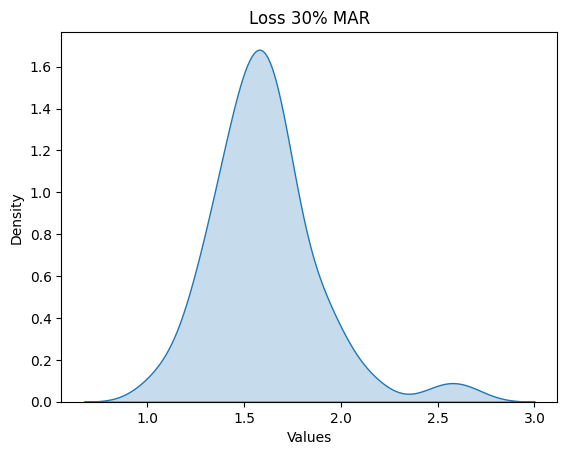

In [44]:
import seaborn as sns
sns.kdeplot(loss_h_mar30, shade=True)  # `shade=True` fills the area under the curve
plt.title('Loss 30% MAR')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

C:\Users\zhossai3\AppData\Local\Temp\ipykernel_6632\1174724183.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(loss_h_mnar30, shade=True)  # `shade=True` fills the area under the curve


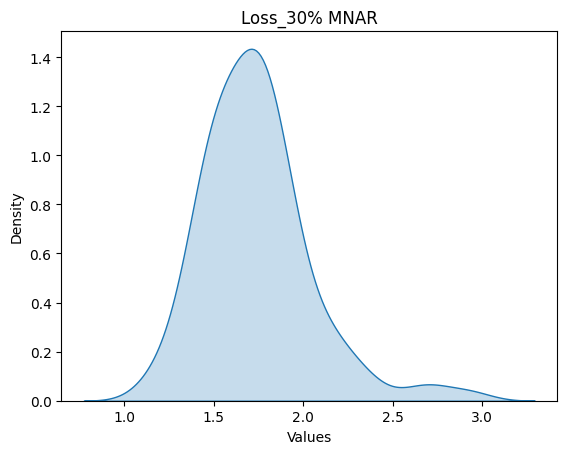

In [45]:
import seaborn as sns
sns.kdeplot(loss_h_mnar30, shade=True)  # `shade=True` fills the area under the curve
plt.title('Loss_30% MNAR')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

In [46]:
feature_names = [f'Feature{i+1}' for i in range(data_mar30.shape[1])]
data_mcar30_pd = pd.DataFrame(data_mar30.numpy(), columns=feature_names)
correlation_matrix_mcar30 = data_mcar30_pd.corr()


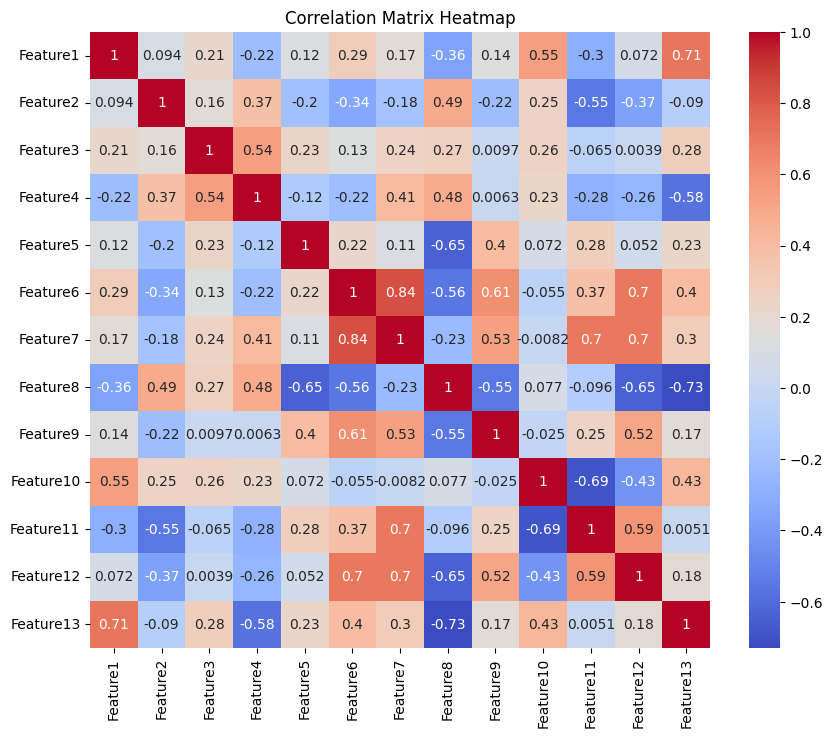

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_mcar30, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()
